In [1]:
import numpy as np
import pandas as pd
# !pip install opencv-python
import cv2
import tensorflow as tf
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(feature0, feature1, feature2):
    feature = {
        'id': _bytes_feature(feature0),
        'image': _bytes_feature(feature1),
        'target': _int64_feature(feature2)
    }
    example_proto = tf.train.Example(features = tf.train.Features(feature = feature))
    return example_proto.SerializeToString()
TRAIN_IMAGE_DIR = 'F:/kaggle/train/'
TRAIN_CSV = 'F:/kaggle/train.csv'
%cd F:/kaggle/train
# Read image and resize it
def read_image(image_path, size = (384, 384)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    return img

F:\kaggle\train


In [2]:
df = pd.read_csv(TRAIN_CSV)
TRAIN_IMAGE_DIR+'/'+df['id'][2][0]+'/'+df['id'][2][1]+'/'+df['id'][2][2]+'/'+df['id'][2]+'.jpg'

'F:/kaggle/train//c/d/4/cd41bf948edc0340.jpg'

In [3]:
df.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [4]:
df.groupby(['landmark_id']).count().sort_values('id',ascending=False)

,id
landmark_id,
138982,6272
126637,2231
20409,1758
83144,1741
113209,1135
177870,1088
194914,1073
149980,971
139894,966


In [5]:
list_of_landmark_ids = list(df.groupby(['landmark_id']).count().sort_values('id',ascending=False)[:10].reset_index()['landmark_id'])
list_of_landmark_ids

[138982, 126637, 20409, 83144, 113209, 177870, 194914, 149980, 139894, 1924]

In [6]:
part = df[df['landmark_id'].isin(list_of_landmark_ids)]

In [7]:
part.head()

,id,landmark_id
14178,00061e23ce736fa9,1924
14179,0060992db5cc819f,1924
14180,008315aa634e14b9,1924
14181,008e6817cf364cb6,1924
14182,00bad7a508ee6666,1924


In [8]:
path = lambda x: TRAIN_IMAGE_DIR+'/'+x['id'][0]+'/'+x['id'][1]+'/'+x['id'][2]+'/'+x['id']+'.jpg'
part['path'] = part.apply(path,axis = 1)
part.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,landmark_id,path
14178,00061e23ce736fa9,1924,F:/kaggle/train//0/0/0/00061e23ce736fa9.jpg
14179,0060992db5cc819f,1924,F:/kaggle/train//0/0/6/0060992db5cc819f.jpg
14180,008315aa634e14b9,1924,F:/kaggle/train//0/0/8/008315aa634e14b9.jpg
14181,008e6817cf364cb6,1924,F:/kaggle/train//0/0/8/008e6817cf364cb6.jpg
14182,00bad7a508ee6666,1924,F:/kaggle/train//0/0/b/00bad7a508ee6666.jpg


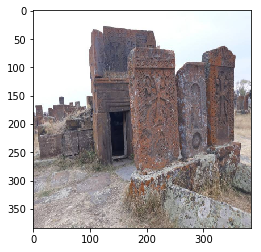

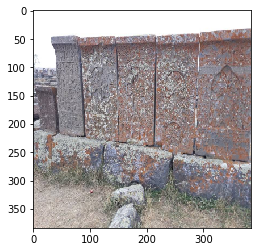

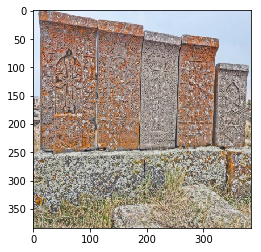

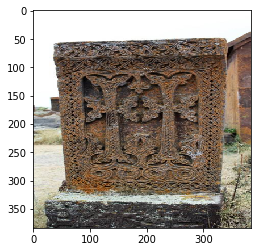

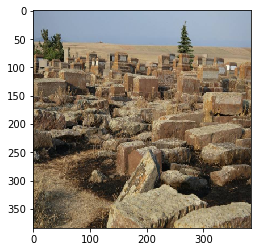

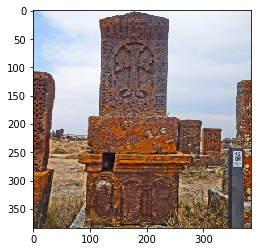

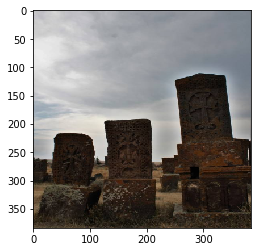

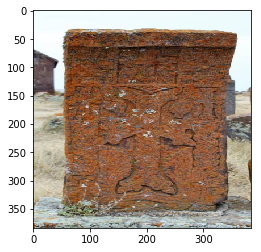

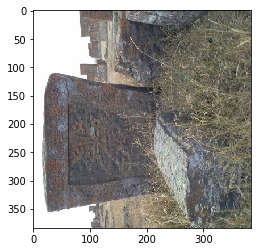

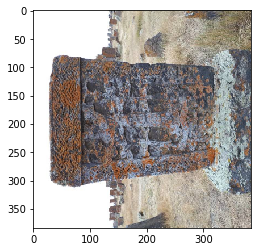

In [9]:
for _, row in part[part['landmark_id']==20409][:10].iterrows():
    img = read_image(str(row['path']))
    plt.imshow(img)
    plt.show()

In [10]:
import random
import os
SEED = 100
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)

In [11]:
from sklearn.model_selection import train_test_split
def get_tf_records(datafr, filename, size = (384, 384)):
    # Get a list of train ids 
#     ids_list = list(data['id'].unique())
    # Write tf records
    with tf.io.TFRecordWriter(filename+'.tfrec') as writer:
        for _, row in datafr.iterrows():
            image_id = row['id']
            img = read_image(str(row['path']), size)
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tostring()
            target = row['landmark_id']
            example = serialize_example(
                    str.encode(image_id), img, target
                )
            writer.write(example)


train_id, test_id = train_test_split(part['id'], test_size = 0.20, random_state = SEED)
train_df = part[part['id'].isin(train_id)]
test_df = part[part['id'].isin(test_id)]

# get_tf_records(train_df, 'train', size = (384, 384))
# get_tf_records(test_df, 'test', size = (384, 384))

In [ ]:
!pip install -q efficientnet

import re
import numpy as np
import pandas as pd

import math
from sklearn import metrics
import tensorflow as tf
import efficientnet.tfkeras as efn
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
# !pip install tqdm -U
from tqdm.notebook import tqdm as tqdm


AUTO = tf.data.experimental.AUTOTUNE

TRAIN_IMAGE_DIR = 'F:\kaggle\train'
DICT_PATH = 'F:\kaggle\\train_encoded.csv'

# Configuration
EPOCHS = 20
BATCH_SIZE = 32
IMAGE_SIZE = [384, 384]

LR = 0.0001
NUMBER_OF_CLASSES = len(list_of_landmark_ids)


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "target": tf.io.FixedLenFeature([], tf.int64)
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    target = tf.cast(example['target'], tf.int32)
    return image, target

# This function load our tf records and parse our data with the previous function
def load_dataset(filenames, ordered = False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTO) 
    return dataset

def arcface_format(image, target):
    return {'inp1': image, 'inp2': target}, target

def get_training_dataset(filenames, ordered = False):
    dataset = load_dataset(filenames, ordered = ordered)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.repeat() 
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(filenames, ordered = True, prediction = False):
    dataset = load_dataset(filenames, ordered = ordered)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    if prediction:
        dataset = dataset.batch(BATCH_SIZE * 4)
    else:
        dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

NUM_TRAINING_IMAGES = df[df['id'].isin(train_id)].shape[0]
NUM_VALIDATION_IMAGES  = df[df['id'].isin(test_id)].shape[0]
print(f'Training with {NUM_TRAINING_IMAGES} images')
print(f'Validating with {NUM_VALIDATION_IMAGES} images')

# Function for a custom learning rate scheduler with warmup and decay
def get_lr_callback():
    lr_start   = 0.000001
    lr_max     = 0.0000005 * BATCH_SIZE
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max    
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
    return lr_callback

# Function to calculate global average precision score
def gap_vector(pred, conf, true, return_x = False):
    '''
    Compute Global Average Precision (aka micro AP), the metric for the
    Google Landmark Recognition competition. 
    This function takes predictions, labels and confidence scores as vectors.
    In both predictions and ground-truth, use None/np.nan for "no label".

    Args:
        pred: vector of integer-coded predictions
        conf: vector of probability or confidence scores for pred
        true: vector of integer-coded labels for ground truth
        return_x: also return the data frame used in the calculation

    Returns:
        GAP score
    '''
    x = pd.DataFrame({'pred': pred, 'conf': conf, 'true': true})
    x.sort_values('conf', ascending = False, inplace = True, na_position = 'last')
    x['correct'] = (x.true == x.pred).astype(int)
    x['prec_k'] = x.correct.cumsum() / (np.arange(len(x)) + 1)
    x['term'] = x.prec_k * x.correct
    gap = x.term.sum() / x.true.count()
    if return_x:
        return gap, x
    else:
        return gap

class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output


def get_model():

    margin = ArcMarginProduct(
        n_classes = NUMBER_OF_CLASSES, 
        s = 64, 
        m = 0.05, 
        name='head/arc_margin', 
        dtype='float32'
        )

    inp = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 3), name = 'inp1')
    label = tf.keras.layers.Input(shape = (), name = 'inp2')
    x0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False)(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x0)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512)(x)
    x = margin([x, label])

    output = tf.keras.layers.Softmax(dtype='float32')(x)

    model = tf.keras.models.Model(inputs = [inp, label], outputs = [output])

    opt = tf.keras.optimizers.Adam(learning_rate = LR)

    model.compile(
        optimizer = opt,
        loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
        ) 

    return model


train_dataset = get_training_dataset('train.tfrec', ordered = False)
val_dataset = get_validation_dataset('test.tfrec', ordered = True, prediction = False)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

model = get_model()
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'/Models/baseline_model_effb0_arcface.h5', 
                                                 monitor = 'val_loss', 
                                                 save_best_only = True, 
                                                 save_weights_only = False)

cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                       mode = 'min', 
                                                       factor = 0.5, 
                                                       patience = 1, 
                                                       verbose = 1, 
                                                       min_delta = 0.0001)


history = model.fit(train_dataset,  
                    steps_per_epoch = STEPS_PER_EPOCH,
                    epochs = EPOCHS,
                    callbacks = [get_lr_callback(), checkpoint],
                    validation_data = val_dataset,
                    verbose = 1
                    )


In [ ]:
model = tf.keras.models.load_model('/Models/baseline_model_effb0_arcface.h5')

val_dataset = get_validation_dataset('test.tfrec', ordered = True, prediction = True)
val_target = val_dataset.map(lambda image, target: target).unbatch()
val_targets = list(next(iter(val_target.batch(NUM_VALIDATION_IMAGES))).numpy())

val_image = val_dataset.map(lambda image, target: image['inp1'])
val_image = val_image.as_numpy_iterator()
target_predictions = []
target_confidences = []
batches = math.ceil(NUM_VALIDATION_IMAGES / (BATCH_SIZE * 4))
for image in tqdm(val_image, total = batches):
    prediction = model.predict(image)
    target_prediction = np.argmax(prediction, axis = -1)
    target_confidence = np.max(prediction, axis = -1)
    target_predictions.extend(list(target_prediction))
    target_confidences.extend(list(target_confidence))

gap = gap_vector(target_predictions, target_confidences, val_targets)
accuracy_score = metrics.accuracy_score(val_targets, target_predictions)
print(f'global average precision score is {gap}')
print(f'accuracy score is {accuracy_score}')

# Inference

In [ ]:
import operator
import gc
import pathlib
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from scipy import spatial
import cv2
!pip install ../input/landmark-baseline-model/Keras_Applications-1.0.8-py3-none-any.whl
!pip install ../input/landmark-baseline-model/efficientnet-1.1.0-py3-none-any.whl
import efficientnet.tfkeras as efn
import math

NUMBER_OF_CLASSES = 81313
IMAGE_SIZE = [384, 384]
LR = 0.0001

class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output


# Function to build our model using fine tunning (efficientnet)
def get_model():

    margin = ArcMarginProduct(
        n_classes = NUMBER_OF_CLASSES, 
        s = 64, 
        m = 0.05, 
        name='head/arc_margin', 
        dtype='float32'
        )

    inp = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 3), name = 'inp1')
    label = tf.keras.layers.Input(shape = (), name = 'inp2')
    x1 = efn.EfficientNetB1(weights = None, include_top = False)(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x1)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512)(x)
    x = margin([x, label])

    output = tf.keras.layers.Softmax(dtype='float32')(x)

    model = tf.keras.models.Model(inputs = [inp, label], outputs = [output])

    opt = tf.keras.optimizers.Adam(learning_rate = LR)

    model.compile(
        optimizer = opt,
        loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
        ) 

    return model


NUM_EMBEDDING_DIMENSIONS = 512
DATASET_DIR = '../input/landmark-image-train/train_encoded.csv'
TEST_IMAGE_DIR = '../input/landmark-recognition-2020/test'
TRAIN_IMAGE_DIR = '../input/landmark-recognition-2020/train'
MODEL = get_model()
MODEL.load_weights('../input/landmark-baseline-model/baseline_model_effb1_arcface.h5')
MODEL = tf.keras.models.Model(inputs = MODEL.input[0], outputs = MODEL.layers[-4].output)
NUM_TO_RERANK = 5


NUM_PUBLIC_TEST_IMAGES = 10345 # Used to detect if in session or re-run.

def read_image(image_path, size = (384, 384)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tostring()
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.reshape(img, [1, 384, 384, 3])
    return img

def generate_embeddings(filepaths):
    image_paths = [x for x in pathlib.Path(filepaths).rglob('*.jpg')]
    num_images = len(image_paths)
    ids = num_images * [None]
    # Generate an empty matrix where we can store the embeddings of each image
    embeddings = np.empty((num_images, NUM_EMBEDDING_DIMENSIONS))
    for i, image_path in enumerate(image_paths):
        ids[i] = image_path.name.split('.')[0]
        image_tensor = read_image(str(image_path), (384, 384))
        prediction = MODEL.predict(image_tensor)
        embeddings[i, :] = prediction
    return ids, embeddings

# This function get the most similar train images for each test image based on cosine similarity
def get_similarities(train_csv, test_directory, train_directory):
    # Get target dictionary
    df = pd.read_csv(train_csv)
    df = df[['id', 'landmark_id']]
    df.set_index('id', inplace = True)
    df = df.to_dict()['landmark_id']
    # Extract the test ids and global feature for the test images
    test_ids, test_embeddings = generate_embeddings(test_directory)
    # Extract the train ids and global features for the train images
    train_ids, train_embeddings = generate_embeddings(train_directory)
    # Initiate a list were we will store the similar training images for each test image (also score)
    train_ids_labels_and_scores = [None] * test_embeddings.shape[0]
    # Using (slow) for-loop, as distance matrix doesn't fit in memory
    for test_index in range(test_embeddings.shape[0]):
        distances = spatial.distance.cdist(
            test_embeddings[np.newaxis, test_index, : ], train_embeddings, 'cosine')[0]
        # Get the indices of the closest images
        top_k = np.argpartition(distances, NUM_TO_RERANK)[:NUM_TO_RERANK]
        # Get the nearest ids and distances using the previous indices
        nearest = sorted([(train_ids[p], distances[p]) for p in top_k], key = lambda x: x[1])
        # Get the labels and score results
        train_ids_labels_and_scores[test_index] = [(df[train_id], 1.0 - cosine_distance) for \
                                                   train_id, cosine_distance in nearest]
        
    del test_embeddings
    del train_embeddings
    gc.collect()
    return test_ids, train_ids_labels_and_scores

# This function aggregate top simlarities and make predictions
def generate_predictions(test_ids, train_ids_labels_and_scores):
    targets = []
    scores = []
    
    # Iterate through each test id
    for test_index, test_id in enumerate(test_ids):
        aggregate_scores = {}
        # Iterate through the similar images with their corresponing score for the given test image
        for target, score in train_ids_labels_and_scores[test_index]:
            if target not in aggregate_scores:
                aggregate_scores[target] = 0
            aggregate_scores[target] += score
        # Get the best score
        target, score = max(aggregate_scores.items(), key = operator.itemgetter(1))
        targets.append(target)
        scores.append(score)
        
    final = pd.DataFrame({'id': test_ids, 'target': targets, 'scores': scores})
    final['landmarks'] = final['target'].astype(str) + ' ' + final['scores'].astype(str)
    final[['id', 'landmarks']].to_csv('submission.csv', index = False)
    return final

def inference_and_save_submission_csv(train_csv, test_directory, train_directory):
    image_paths = [x for x in pathlib.Path(test_directory).rglob('*.jpg')]
    test_len = len(image_paths)
    if test_len == NUM_PUBLIC_TEST_IMAGES:
        # Dummy submission
        shutil.copyfile('../input/landmark-recognition-2020/sample_submission.csv', 'submission.csv')
        return 'Job Done'
    else:
        test_ids, train_ids_labels_and_scores = get_similarities(train_csv, test_directory, train_directory)
        final = generate_predictions(test_ids, train_ids_labels_and_scores)
        return final
    
final = inference_and_save_submission_csv(DATASET_DIR, TEST_IMAGE_DIR, TRAIN_IMAGE_DIR)